# Neuroplant image analysis
This notebook analyzes chemotaxis assays as part of the neuroplant project, which seeks to use *C. elegans* nematodes to identify neuroactive compounds in plants.

### To-dos
- connect to metadata spreadsheets
- decode strains and compounds
- integrate diagnostic plots into functions
- integrate option for diag plots into main loop

## First, load libraries

In [1]:
import pandas as pd
import time
import skimage
from skimage import feature
from skimage import morphology
from skimage import measure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import pathlib
import csv
import seaborn as sns
#import gspread
#import pydrive

start = time.time()

## File parameters

In [2]:
base_folder = pathlib.Path('/Users/adam/Documents/Neuroplant/')
image_location = base_folder.joinpath('Images')
results_location = base_folder.joinpath('automated_analysis_results')

## Functions for running analysis
### Load data

In [ ]:
def load_image_data(data_location, plate_id):

    pre_file = data_location.joinpath(plate_id + '_Pre.tif')
    pre_image = skimage.io.imread(pre_file)
    
    fin_file = data_location.joinpath(plate_id + '_Fin.tif')
    fin_image = skimage.io.imread(fin_file)

    return pre_image, fin_image

def crop_to_one_well(pre_image, fin_image, well_id):
    # select bounds of the lane we're working on now
    if well_id == 'P':
        upper_boundary = 23000
        lower_boundary = pre_image.shape[0]
    elif well_id == 'Q':
        upper_boundary = 14800
        lower_boundary = 23000
    elif well_id == 'R':
        upper_boundary = 6900
        lower_boundary = 14800
    elif well_id == 'S':
        upper_boundary = 0
        lower_boundary = 6900
    else:
        raise ValueError('Lane label not recognized.')

    pre_image = pre_image[upper_boundary:lower_boundary, :]
    fin_image = fin_image[upper_boundary:lower_boundary, :]
        
    # Crop larger image to make before and after images the same size
    x_min = 0
    x_max = min(pre_image.shape[1], fin_image.shape[1])
    y_min = 0
    y_max = min(pre_image.shape[0], fin_image.shape[0])
    pre_image = pre_image[y_min:y_max, x_min:x_max]
    fin_image = fin_image[y_min:y_max, x_min:x_max]
    
    return pre_image, fin_image

### Find the worms

In [4]:
def find_worms(pre_image, fin_image):
    feature_find_start = time.time()
    
    ## Subtract background
    bkg_subtract = np.subtract(pre_image.astype('int16'),
                               fin_image.astype('int16'))
    bkg_subtract[bkg_subtract < 0] = 0
    bkg_subtract = bkg_subtract.astype('uint8')

    ## Threshold to get binary image
    thresh = skimage.filters.threshold_otsu(bkg_subtract)
    binarized = bkg_subtract > thresh
    # print('Binarization threshold is', str(thresh))

    ## Find features in binary image
    labeled_array, num_features = ndi.label(binarized)
    all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_image,
                                      coordinates='rc')

    filtered_regions = []
    for region in all_regions:
        area = region.area
        if area >= 2000 and area <=30000:# and region.major_axis_length < 500:
            filtered_regions.append(region)
        
#     print('Worm finding and filtering took', str(int(time.time() - feature_find_start)), 'seconds.')
    
    return filtered_regions

### Save worm locations

In [5]:
def save_worm_locations(filename, worms):
    with open(filename, 'w', newline='') as csvfile:
        worm_writer = csv.writer(csvfile, delimiter=',')
        worm_writer.writerow([' ','X','Y']) # header row
        
        worm_num = 1
        for worm in worms:
            worm_writer.writerow([worm_num, worm.centroid[0], worm.centroid[1]])
            worm_num += 1

### Calculate the chemotaxis index

In [6]:
def calc_chemotaxis_index(worm_regions):
    ## Assign features to zones of the plate
#     left_area_boundary = 8700 #int(fin_image.shape[1]/3)
#     right_area_boundary = 12000 #int(2 * (fin_image.shape[1] / 3))
    left_area_boundary = int(21000*2/5) #8000
    right_area_boundary = int(21000*3/5)

    left_side_worms = [worm for worm in worm_regions if worm.centroid[1] <= left_area_boundary]
    middle_worms = [worm for worm in worm_regions 
                    if worm.centroid[1] > left_area_boundary and worm.centroid[1] < right_area_boundary]
    right_side_worms = [worm for worm in worm_regions if worm.centroid[1] >= right_area_boundary]
    
#                       filtered_regions[[centroid[1] <= left_area_boundary 
#                                         for centroid in filtered_regions['centroid']]]
#     middle_worms = filtered_regions[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
#                                      for centroid in filtered_regions['centroid']]]
#     right_side_worms = filtered_regions[[centroid[1] > right_area_boundary 
#                                          for centroid in filtered_regions['centroid']]]
    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(worm_regions)

    chemotaxis_index = ((worms_in_right_region-worms_in_left_region) 
                        / (worms_in_right_region+worms_in_left_region))
    print('Chemotaxis index is', str(chemotaxis_index))
    
    x_coords = []
    y_coords = []
    for worm in worm_regions:
#         x_sum += worm.centroid[0]
#         y_sum += worm.centroid[1]
        x_coords.append(worm.centroid[0])
        y_coords.append(worm.centroid[1])
    
    centroid = (sum(x_coords)/len(x_coords), sum(y_coords)/len(y_coords))
    
    return chemotaxis_index, centroid

## Do the image analysis

In [7]:
# load_start = time.time()
# well_id = 'P'
# plate_id = 'NPP001'
# pre_image, fin_image = load_image_data(image_location, plate_id, well_id)

# analysis_start = time.time()
# print('Image loading took', str(int(analysis_start-load_start)), 'seconds.')
# worms = find_worms(pre_image, fin_image)
# save_worm_locations(results_location.joinpath(plate_id + '_automatedAnalyzer_' + well_id + '.csv'), worms)
# chemotaxis_index = calc_chemotaxis_index(worms)

# print('Image analysis took', str(int(time.time()-analysis_start)), 'seconds.')
# print('Entire process took', str(int(time.time()-start)), 'seconds.')

## Loop through all plates

In [8]:
loop_start = time.time()

# results_list = []
for image in image_location.glob('NPP*Fin.tif'): #image_location.glob('Scan*Fin.tif'): 
    plate_start = time.time()
    plate_id = image.stem[0:6]
    if image.parent.joinpath(plate_id + '_Pre.tif').exists is False:
        raise NameError('No matching pre-image found.')
    
    # Load the entire image
    pre_image, fin_image = load_image_data(image_location, plate_id)
    print('Image load took', str(int(time.time()-plate_start)), 'seconds.')
    
    results_list = []
    for well_id in ['P', 'Q', 'R', 'S']:
        # Process one well at a time
        cropped_pre_image, cropped_fin_image = crop_to_one_well(pre_image, fin_image, well_id)
#         cropped_pre_image = pre_image
#         cropped_fin_image = fin_image
        worms = find_worms(cropped_pre_image, cropped_fin_image)
        
        # Save the results
        filename = results_location.joinpath(plate_id + '_automatedAnalyzer_' + well_id + '.csv')
        save_worm_locations(filename, worms)
        
        # Calculate chemotaxis index and gather into a dataframe
        chemotaxis_index, centroid = calc_chemotaxis_index(worms)
        results_dict = {'Plate_id': plate_id,
                        'Well_id': well_id,
                        'results_file': filename,
                        'chemotaxis_index': chemotaxis_index,
                        'centroid_x': centroid[0],
                        'centroid_y': centroid[1]}
        results_list.append(results_dict)
    
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(path_or_buf=results_location.joinpath(plate_id + '_chemotaxis_summary.csv'))
        
    print('Finished', plate_id, 'in', str(int(time.time()-plate_start)), 'seconds.')

# results_df = pd.DataFrame(results_list)
# results_df.to_csv(path_or_buf=base_folder.joinpath('chemotaxis_summary.csv'))
print('Finished everything in', str(int(time.time()-loop_start)), 'seconds.')

Image load took 34 seconds.
Chemotaxis index is 0.503448275862069
Chemotaxis index is 0.39705882352941174
Chemotaxis index is 0.2608695652173913
Chemotaxis index is 0.43769968051118213
Finished NPP001 in 63 seconds.
Image load took 33 seconds.
Chemotaxis index is 0.38823529411764707
Chemotaxis index is 0.4646153846153846
Chemotaxis index is 0.7551020408163265
Chemotaxis index is 0.5151515151515151
Finished NPP002 in 63 seconds.
Image load took 27 seconds.
Chemotaxis index is -0.19672131147540983
Chemotaxis index is 0.10043668122270742
Chemotaxis index is -0.12612612612612611
Chemotaxis index is 0.36
Finished NPP003 in 57 seconds.
Image load took 25 seconds.
Chemotaxis index is 0.13725490196078433
Chemotaxis index is 0.7435897435897436
Chemotaxis index is 0.4453125
Chemotaxis index is 0.5915492957746479
Finished NPP004 in 55 seconds.
Image load took 20 seconds.
Chemotaxis index is -0.09090909090909091
Chemotaxis index is -0.5752212389380531
Chemotaxis index is -0.16393442622950818
Chemo

# Diagnostic plots

In [19]:
plate_id = 'NPP007' #'Scan001'
well_id = 'S'

# #     props = [a for a in dir(all_regions[0]) if not a.startswith('_')]
# props = ['area', 'convex_area', 'bbox', 'centroid']

# region_df = pd.DataFrame([{prop: getattr(worm, prop) for prop in props} for worm in worms])

# ## Filter features
# filtered_regions = region_df[
#     (region_df['area'] >= 2000) &
#     (region_df['area'] <= 30000)]

## Load results of manual analysis for this plate

In [10]:
results_files = base_folder.joinpath('Manual_analysis_results').glob(plate_id + '*' + well_id + '.csv')
# results_files = data_folder.glob('NPP005*.csv')

manual_analysis_results = []
for file in results_files:
    this_experiment_df = pd.read_csv(file, index_col=' ')
    plate_id = file.stem[0:6]
    this_experiment_df['plate_id'] = plate_id
    well_id = file.stem[-1].upper()
    this_experiment_df['well_id'] = well_id
    user = file.stem.split('_')[1]
    this_experiment_df['user'] = user
    manual_analysis_results.append(this_experiment_df)
manual_analysis_results = pd.concat(manual_analysis_results)

## Correct for well location in manual analysis results
if well_id == 'P':
    upper_boundary = 23000
    lower_boundary = pre_image.shape[0]
elif well_id == 'Q':
    upper_boundary = 14800
    lower_boundary = 23000
elif well_id == 'R':
    upper_boundary = 6900
    lower_boundary = 14800
elif well_id == 'S':
    upper_boundary = 0
    lower_boundary = 6900
    
manual_analysis_results['Y'] = manual_analysis_results['Y'] - upper_boundary

manual_analysis_results['Y'].describe()

count     409.000000
mean     3011.804401
std      1854.237131
min         4.000000
25%      1381.000000
50%      2976.000000
75%      4488.000000
max      6400.000000
Name: Y, dtype: float64

In [24]:
pre_image.shape

(29883, 21069)

## Plot results of feature find for example plate

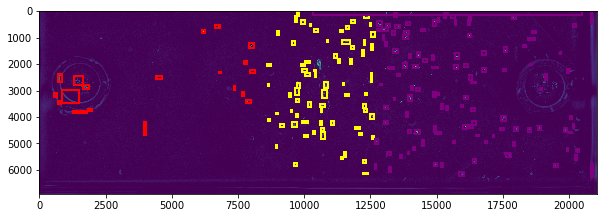

In [21]:
## Load the images
pre_image, fin_image = load_image_data(image_location, plate_id)

## Choose well to look at
cropped_pre_image, cropped_fin_image = crop_to_one_well(pre_image, fin_image, well_id)

## Subtract background
bkg_subtract = np.subtract(cropped_pre_image.astype('int16'),
                           cropped_fin_image.astype('int16'))
# bkg_subtract = np.subtract(pre_image.astype('int16'),
#                            fin_image.astype('int16'))
bkg_subtract[bkg_subtract < 0] = 0
bkg_subtract = bkg_subtract.astype('uint8')

## Threshold to get binary image
thresh = skimage.filters.threshold_otsu(bkg_subtract)
binarized = bkg_subtract > thresh
# print('Binarization threshold is', str(thresh))

## Find features in binary image
labeled_array, num_features = ndi.label(binarized)
all_regions = measure.regionprops(label_image=labeled_array, intensity_image=cropped_fin_image,
                                  coordinates='rc')

## Filter features
filtered_regions = []
for region in all_regions:
    area = region.area
    if area >= 2000 and area <=30000:# and region.major_axis_length < 500:
        filtered_regions.append(region)

props = ['area', 'convex_area', 'bbox', 'centroid']
region_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in filtered_regions])

            
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(bkg_subtract)

left_area_boundary = int(2*fin_image.shape[1]/5)
right_area_boundary = int(3 * (fin_image.shape[1] / 5))
left_side_worms = region_df[[centroid[1] <= left_area_boundary 
                                    for centroid in region_df['centroid']]]
middle_worms = region_df[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
                                 for centroid in region_df['centroid']]]
right_side_worms = region_df[[centroid[1] > right_area_boundary 
                                     for centroid in region_df['centroid']]]


for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

for index, row in middle_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='yellow', linewidth=2)
    ax.add_patch(rect)
    
for index, row in right_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='purple', linewidth=2)
    ax.add_patch(rect)
    
# sns.scatterplot(x='X', y='Y', s=2,
#                 data=manual_analysis_results)
    
# ax.set_ylim(2000, 4000)
# ax.set_xlim(0, 2500);
# fig.savefig('../filtered_regions.pdf')

In [12]:
# all_regions[0].centroid
x_coords = []
y_coords = []
for region in worms:
    x_coords.append((region.centroid[0]))
    y_coords.append((region.centroid[1]))

In [13]:
sum(x_coords) / len(x_coords)

2949.6315527715037

## Show results in detailed region

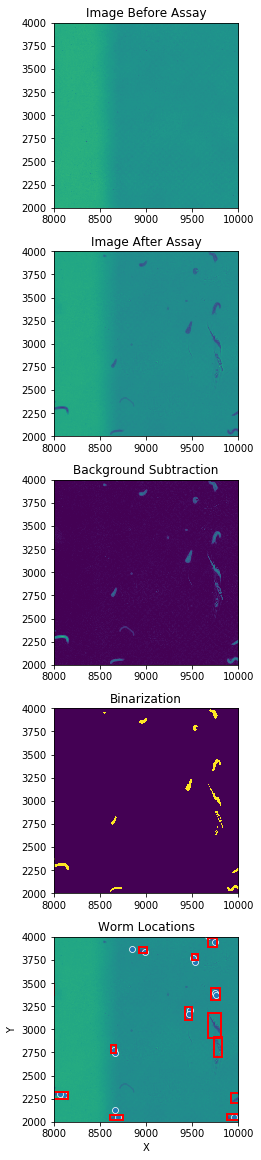

In [14]:
x_min = 8000
x_max = 10000
y_min = 2000
y_max = 4000

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 16), constrained_layout=True)
axes[0].imshow(cropped_pre_image)#[y_min:y_max, x_min:x_max])
axes[0].set_title('Image Before Assay')

axes[1].imshow(cropped_fin_image)#[y_min:y_max, x_min:x_max])
axes[1].set_title('Image After Assay')

axes[2].imshow(bkg_subtract)#[y_min:y_max, x_min:x_max])
axes[2].set_title('Background Subtraction')

axes[3].imshow(binarized)#[y_min:y_max, x_min:x_max])
axes[3].set_title('Binarization')

axes[4].imshow(cropped_fin_image)#[y_min:y_max, x_min:x_max])
axes[4].set_title('Worm Locations')
for index, row in region_df.iterrows():
    minr, minc, maxr, maxc = row['bbox']
#     minr -= y_min
#     minc -= x_min
#     maxr -= y_min
#     maxc -= x_min
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    axes[4].add_patch(rect)

sns.scatterplot(x='X', y='Y', ax=axes[4],#s=1,
                data=manual_analysis_results)#.loc[(manual_analysis_results['well_id']==well_id) &
#                                                  (manual_analysis_results['X']<=x_max-x_min) &
#                                                  (manual_analysis_results['Y']<=y_max-y_min)])
#                                                  (manual_analysis_results['Y']>=y_min) &
#                                                  (manual_analysis_results['X']>=x_min) &

for ax in axes:
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

fig.savefig('../analysis_pipeline.pdf')

## Show images of all the things we think are worms

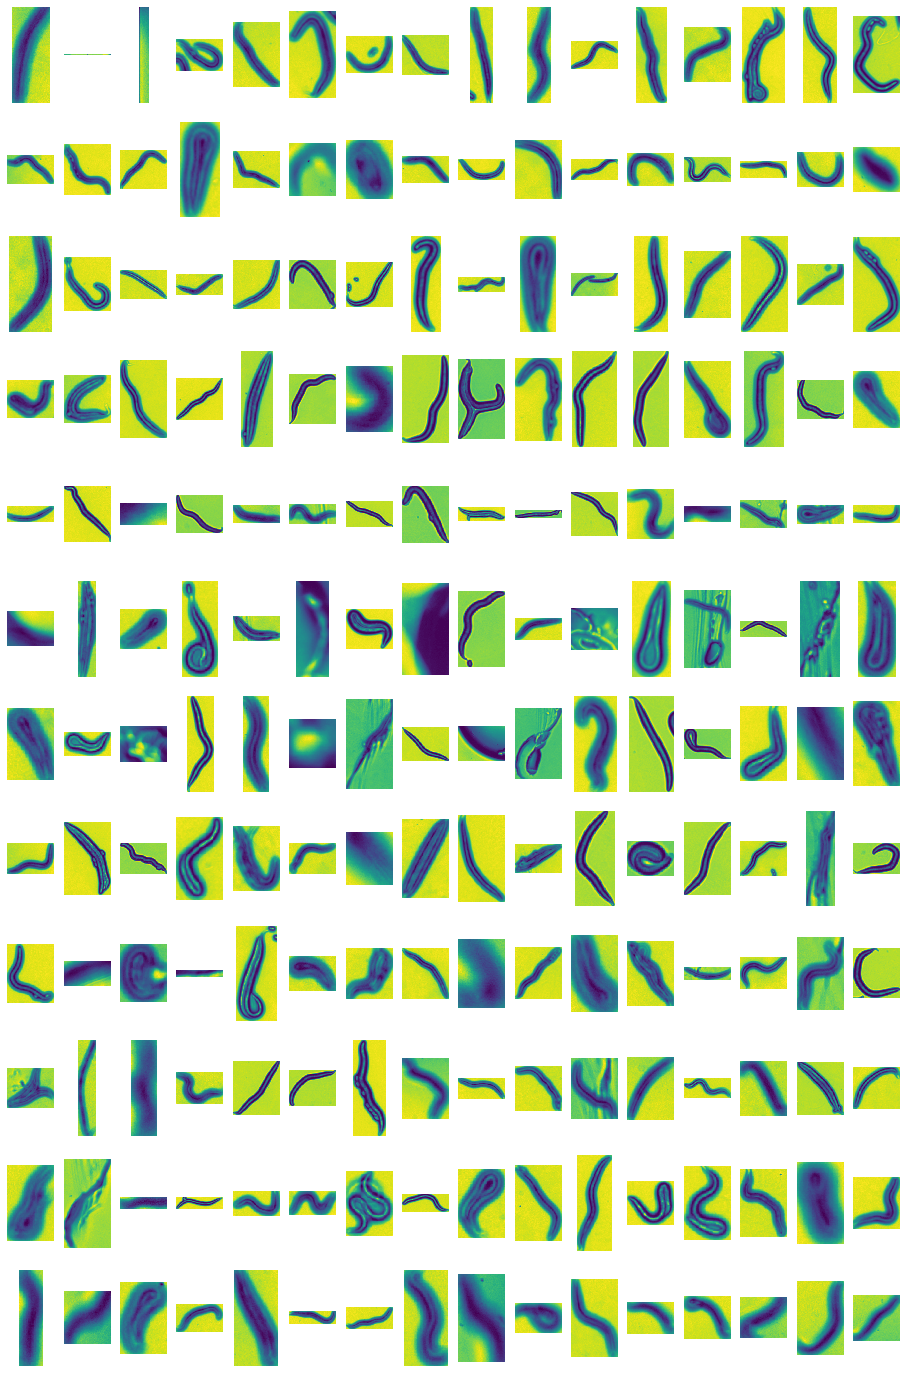

In [15]:
nrows = int(len(filtered_regions) / 16)
fig, axes = plt.subplots(nrows=nrows, ncols=16, figsize=(16, 25))
pad = 0
bboxes = region_df['bbox'].values
region_num = 0
for row in range(0,nrows):
    for col in range(0,16):
        bbox = bboxes[region_num]
        axes[row, col].imshow(cropped_fin_image[bbox[0]-pad:bbox[2]+pad,bbox[1]-pad:bbox[3]+pad])
        axes[row, col].axis('off')
        region_num += 1

fig.savefig('../worm_collage.pdf')

In [20]:
# plt.hist(pre_image.flatten(), bins=16)
# plt.show()

In [21]:
# plt.hist(fin_image.flatten(), bins=16)
# plt.show()

In [22]:
# plt.hist(bkg_subtract.flatten(), bins=16)
# plt.show()

In [23]:
print('Notebook ran in', str(int(time.time()-start)), 'seconds.')

Notebook ran in 2196 seconds.
